<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/001_not_checkboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [3]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, :self.input_dim//2].reshape((len(x), -1,))
        x_b = x[:, self.input_dim//2:].reshape((len(x), -1, ))

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.concat((x_a, y_b), axis=1)

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow, forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [4]:
def rescale(x, lo, hi):
    """Rescale a tensor to [lo,hi]."""
    assert(lo < hi), "[rescale] lo={0} must be smaller than hi={1}".format(lo,hi)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(hi-lo)
    new_center = lo + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [5]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.20,
                                                   random_state=42)

#X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

X_train = torch.tensor(X_train) + torch.rand_like(torch.tensor(X_train)).div_(256.)
X_train = rescale(X_train, 0., 1.).numpy()

train_data = Data(X_train)


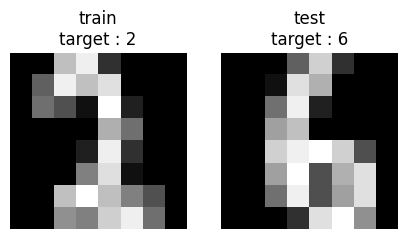

In [6]:
random_number = torch.randint(0,9,[1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [7]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [8]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  154.64832051595053
Epoch :  100   -----------> Loss :  36.14556121826172
Epoch :  200   -----------> Loss :  -22.045594851175945
Epoch :  300   -----------> Loss :  -69.24445215861003
Epoch :  400   -----------> Loss :  -108.7064208984375
Epoch :  500   -----------> Loss :  -131.92313130696616
Epoch :  600   -----------> Loss :  -107.02464294433594
Epoch :  700   -----------> Loss :  -162.4891815185547
Epoch :  800   -----------> Loss :  -172.80961100260416
Epoch :  900   -----------> Loss :  -181.5213623046875
Epoch :  1000   -----------> Loss :  -185.18494160970053


In [9]:
test = prior.sample((50,))
test

tensor([[ 0.5461, -1.7746,  0.0237,  ..., -1.1736, -1.4038,  0.6314],
        [-0.9267,  0.9116,  0.3567,  ..., -0.6138, -1.0392,  0.6637],
        [ 0.4206,  1.0511, -1.1594,  ...,  0.2336, -0.4658, -0.1160],
        ...,
        [ 1.0040, -0.9197,  0.9142,  ...,  1.2108, -1.2792,  1.1735],
        [-2.4522, -0.9288,  0.9313,  ...,  0.9771,  1.3376,  1.3721],
        [ 1.0273,  0.1288, -1.0657,  ...,  0.9094, -0.0595,  1.4527]])

In [10]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 4.2717e-05, -1.1067e-02, -1.0854e-01,  ...,  2.0185e-01,
          4.3384e-02, -6.4797e-03],
        [ 1.4426e-04,  6.2482e-02,  4.2810e-01,  ...,  3.1461e-01,
          1.6948e-02, -1.4663e-02],
        [ 1.1760e-04,  1.2659e-02,  2.0145e-01,  ...,  1.4180e-01,
         -9.5150e-03,  5.9318e-03],
        ...,
        [ 1.7698e-04, -1.4253e-02,  3.3111e-01,  ...,  8.2509e-01,
          1.6337e-01, -5.9925e-03],
        [ 1.6327e-04, -1.3921e-02, -3.5069e-02,  ...,  7.6900e-01,
          1.7010e-01, -2.5359e-02],
        [ 1.0294e-04,  8.6203e-03,  5.3722e-01,  ...,  5.9757e-01,
          3.3142e-02,  1.1471e-02]], grad_fn=<MulBackward0>)

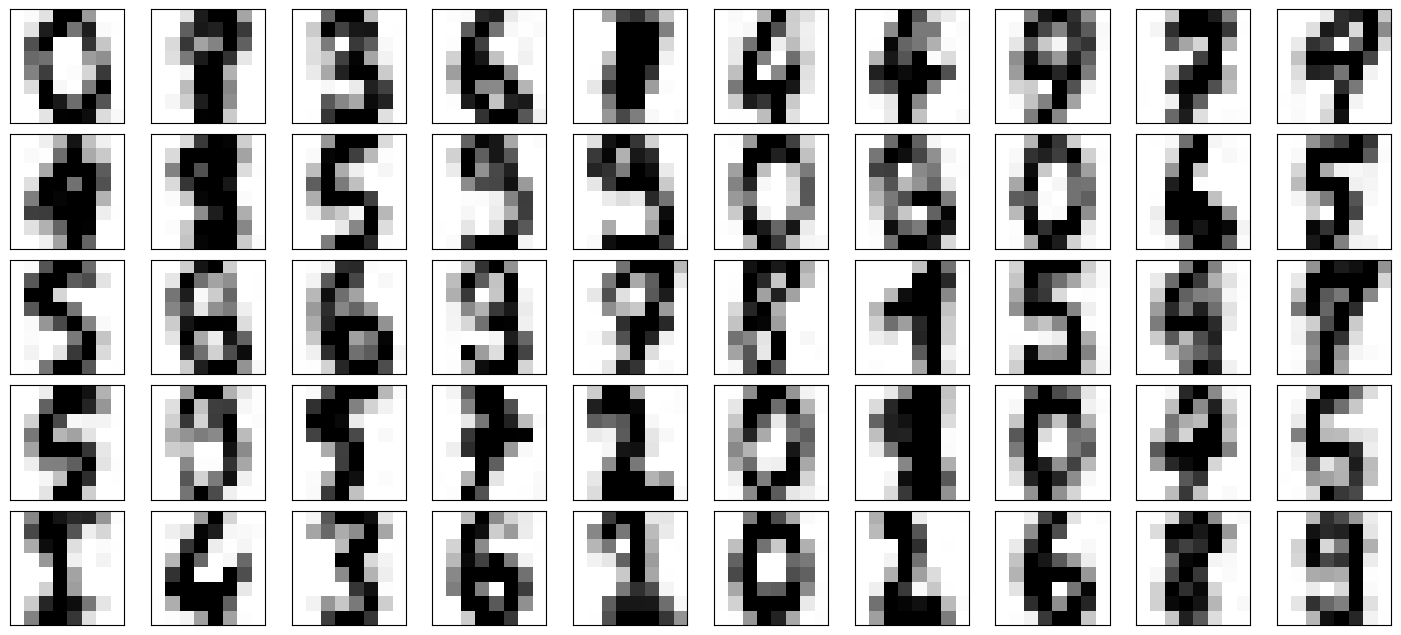

In [11]:
test = prior.sample((1797,))
sonuc = torch.nn.ReLU()(model.f_inv(test))

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
fig.show()


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [13]:
forward, logdet_j = model.forward(torch.tensor(X_test))
backward = model.f_inv(forward)

In [14]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(360, 2)


In [15]:
projected_raw = pca.fit_transform(X_test)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(360, 2)


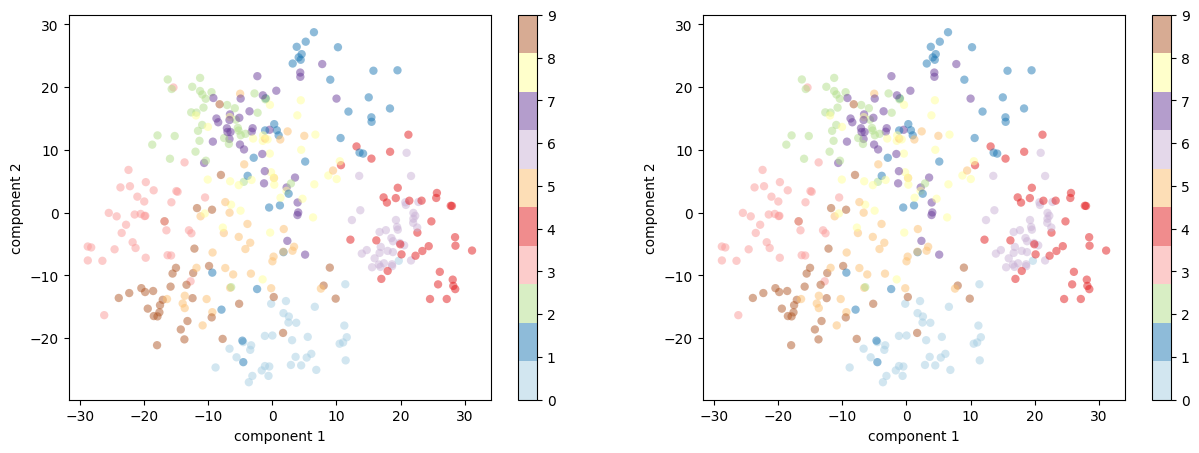

In [16]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()